In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import numpy as np
from collections import Counter
import keras
from keras import layers
from keras import ops
from livelossplot import PlotLossesKerasTF

In [11]:
data = pd.read_csv("spooky-author-identification/train.zip")

In [18]:
# !pip install tokenizers
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

def get_bpe_tokenizer(corpus_file, vocab_size=8000):
    tokenizer = Tokenizer(models.BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, special_tokens=["[PAD]", "[UNK]"])
    tokenizer.train([corpus_file], trainer)
    return tokenizer

In [ ]:
maxlen = 100
vocab_size = 20000

In [51]:
tokenizer = get_bpe_tokenizer("corpus.txt", vocab_size)

In [52]:
encoded = tokenizer.encode("He shall find that I can feel my injuries; he shall learn to dread my revenge"" A few days after he arrived.")
print("Token IDs:", encoded.ids)
print("Tokens:", encoded.tokens)

Token IDs: [295, 639, 735, 130, 17, 369, 565, 133, 10048, 7, 109, 639, 4307, 101, 1385, 133, 3550, 9, 686, 912, 394, 109, 2013, 5]
Tokens: ['He', 'shall', 'find', 'that', 'I', 'can', 'feel', 'my', 'injuries', ';', 'he', 'shall', 'learn', 'to', 'dread', 'my', 'revenge', 'A', 'few', 'days', 'after', 'he', 'arrived', '.']


In [53]:
X = data.text.values
y = data.author.values

In [54]:
def tokenize(X):
    return [tokenizer.encode(sentence) for sentence in X]
    # return re.findall(r'\w+|[^\w\s]', sentence)


def pipe(value, *funcs):
    for func in funcs:
        value = func(value)
    return value

In [55]:
X = [tokenizer.encode(sentence).ids for sentence in data.text]

In [56]:
np.quantile(np.array([len(s) for s in X]),q = [0.5,0.6,0.7,0.8,0.9,0.99,1])

array([ 27.,  32.,  37.,  44.,  56., 100., 887.])

In [57]:
X = [tokenizer.encode(sentence).ids for sentence in data.text]
X = keras.utils.pad_sequences(X, maxlen=maxlen)

In [58]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y

array([0, 1, 0, ..., 0, 0, 1])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(len(X_train), "Training sequences")
print(len(X_test), "Validation sequences")

14684 Training sequences
4895 Validation sequences


In [60]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        """
        embed_dim: dimensión de embedings
        num_heads: número de cabezas
        ff_dim: número de neuronas de la capa densa
        rate: dropout rate
        """

        super().__init__() # Hace la llamada al constructor de la clase padre para que todo lo que hiciese este, lo haga el nuestro también
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), 
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) # epsilon es un término que se suma a la varianza para evitar divisiones por 0
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs) # Porque el att está pensado para hacer atención cruzada (toma de uno los q's y de la otra las k's y las v's). 
        attn_output = self.dropout1(attn_output)                                                          # Si pongo los dos iguales, hago atención "normal"
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    # No trabajamos con unos embeddings preentrenados, si no que empezamos con embeddings aleatorios y se van aprendiendo durante el entrenamiento

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        """
        maxlen: longitud máxima de la entrada (si es menor rellena con <eos>)
        vocab_size: tamaño del vocabulario
        embed_dim: dimensión del embedding
        """
        super().__init__() # Hereda de Layer de keras, por lo que tendrá todo lo que tenga esa clase más lo que le añadamos ahora
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim) # entra un vector one-hot del vocabulario
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim) # entra un vector de tamaño de la longitud máxima, 
                                                                                # con un 1 indicando la posición de la palabra y 0 lo demás

    def call(self, x):
        """
        x: matriz en la que tenemos una fila por cada review y cada columna representa cada una de las palabras de la review (con números, i.e. 1 es la 1º palabra del vocab,...)
        """
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [61]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
rate = 0.5

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas). Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
x = layers.Dropout(rate)(x)
x = layers.Dense(40, activation="relu")(x)
x = layers.Dropout(rate)(x)
outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

model = keras.Model(inputs=inputs, outputs=outputs)

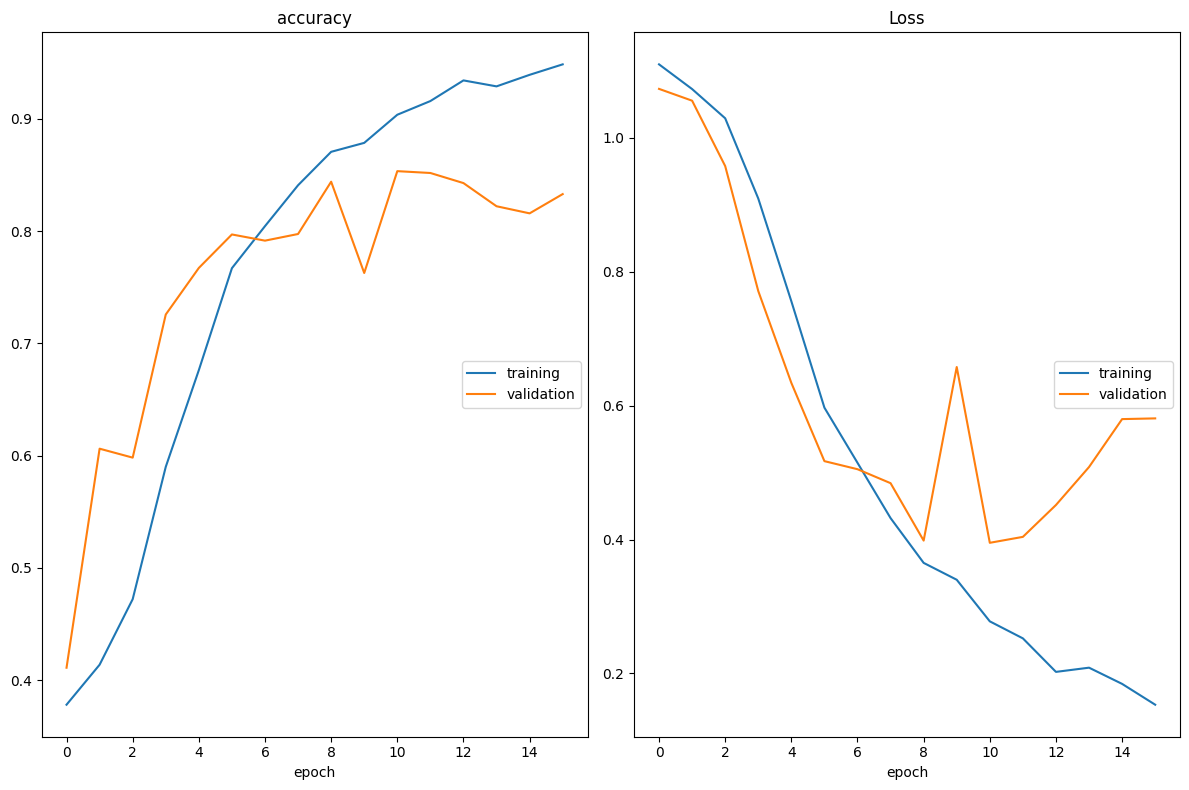

accuracy
	training         	 (min:    0.378, max:    0.948, cur:    0.948)
	validation       	 (min:    0.411, max:    0.853, cur:    0.833)
Loss
	training         	 (min:    0.153, max:    1.110, cur:    0.153)
	validation       	 (min:    0.395, max:    1.073, cur:    0.581)
459/459 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9504 - loss: 0.1446 - val_accuracy: 0.8329 - val_loss: 0.5809


In [ ]:
model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Definir el callback de Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitoriza la pérdida en la validación
    patience=5,            # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True # Restaura los mejores pesos al finalizar
)

history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=15, 
    validation_data=(X_test, y_test), 
    callbacks=[PlotLossesKerasTF(),
               early_stopping]
)

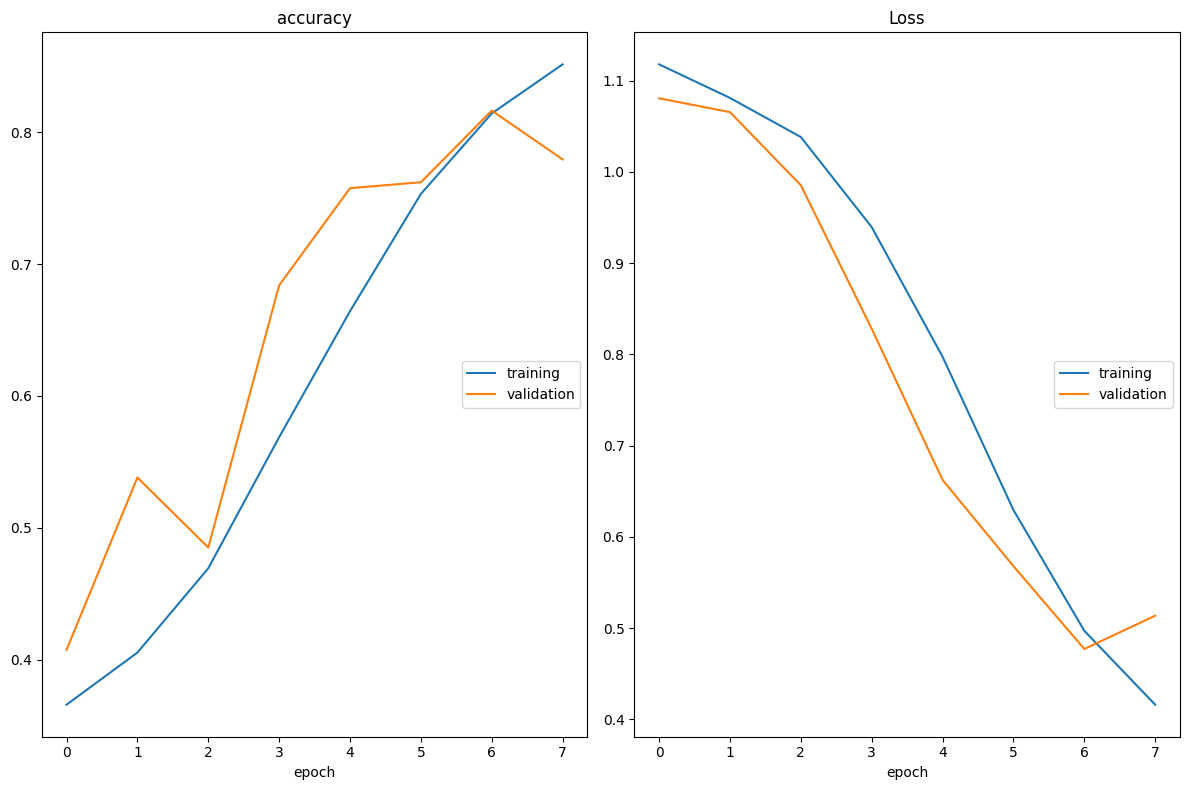

accuracy
	training         	 (min:    0.366, max:    0.852, cur:    0.852)
	validation       	 (min:    0.407, max:    0.817, cur:    0.780)
Loss
	training         	 (min:    0.416, max:    1.118, cur:    0.416)
	validation       	 (min:    0.477, max:    1.081, cur:    0.513)
459/459 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8497 - loss: 0.4172 - val_accuracy: 0.7796 - val_loss: 0.5135
Epoch 9/15
395/459 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8733 - loss: 0.3632

KeyboardInterrupt: 

In [67]:
l_embed_dim = [32,64,128]  # Embedding size for each token
l_num_heads = [2,4,6,8]  # Number of attention heads
l_ff_dim = [32,64,128]  # Hidden layer size in feed forward network inside transformer
l_rate = [0.1,0.5,0.7]

best_loss = 1
best_parms = {}

for embed_dim in l_embed_dim:
    for num_heads in l_num_heads:
        for ff_dim in l_ff_dim:
            for l_rate in l_rate:

                # Define model
                inputs = layers.Input(shape=(maxlen,))
                embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
                x = embedding_layer(inputs)
                x = TransformerBlock(embed_dim, num_heads, ff_dim)(x) # De aquí sale Z: una matriz donde cada fila es el vector de cada token enriquecido
                x = layers.GlobalAveragePooling1D()(x) # Usamo GAP para reducir la dimensionalidad (Hace la media por filas). Otra opción: layers.flatten(), problema: aumenta mucho la dimensión
                x = layers.Dropout(rate)(x)
                x = layers.Dense(40, activation="relu")(x)
                x = layers.Dropout(rate)(x)
                outputs = layers.Dense(3, activation="softmax")(x) # Tendremos la probabilidad de cada una de las clases

                model = keras.Model(inputs=inputs, outputs=outputs)

                # Compile
                model.compile(
                    optimizer= keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
                )

                # Definir el callback de Early Stopping
                early_stopping = keras.callbacks.EarlyStopping(
                    monitor='val_loss',    # Monitoriza la pérdida en la validación
                    patience=5,            # Número de épocas sin mejora antes de detener el entrenamiento
                    restore_best_weights=True # Restaura los mejores pesos al finalizar
                )

                # Train
                history = model.fit(
                    X_train, 
                    y_train, 
                    batch_size=32, 
                    epochs=15, 
                    validation_data=(X_test, y_test), 
                    callbacks=[PlotLossesKerasTF(),
                               early_stopping]
                )

                # Guardar parámetros
                if early_stopping.best < best_loss:

                    best_parms["embed_dim"] = embed_dim
                    best_parms["num_heads"] = num_heads
                    best_parms["ff_dim"] = ff_dim
                    best_parms["l_rate"] = l_rate

                    best_loss = early_stopping.best
